# "An investigation of the false discovery rate and the misinterpretation of p-values" by David Colquhoun published in Royal Society Open Science

##### Some general settings

In [1]:
%matplotlib inline
from pylab import*
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower

In [2]:
def norm_pdf(x, mu, sd):
    dist = stats.norm(mu, sd)
    return dist.pdf(x)

In [3]:
def run_simulation(mean, sigma, nobs, nsim=10000):
    pval, diff = np.zeros(nsim), np.zeros(nsim)
    for r in range(nsim):
        s1, s2 = np.random.multivariate_normal(mean, sigma, nobs).T
        t, p = stats.ttest_ind(s1, s2, equal_var=False, nan_policy='omit')
        diff[r] = np.mean(s1) - np.mean(s2)
        pval[r] = p   
    return diff, pval

In [4]:
nsim = 10000

## Figure 3. Results of simulated t-tests where the null hypothesis is true.  Two groups of observations have identical true means and SD of 1.

In [5]:
mean0 = np.array([0.0, 0.0])
sd0 = 1.0
sigma0 = np.array([[sd0**2, 0.0], [0.0, sd0**2]]) #covariance matrix
diff0, pval0 = run_simulation(mean0, sigma0, 16, nsim=nsim)

### A, The distribution of 'observed' differences between means.  It is centered on zero as the average difference is close to zero.

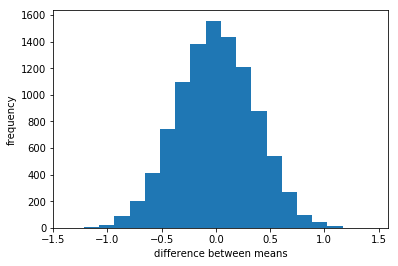

In [6]:
plt.hist(diff0, bins=20);
xlabel('difference between means')
ylabel('frequency');

### B, The distribution of the p-values is flat (uniform).

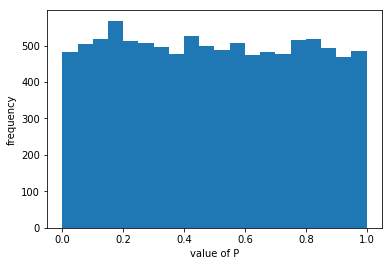

In [7]:
plt.hist(pval0, bins=20);
xlabel('value of P')
ylabel('frequency');

In [8]:
Psig = 0.05
nsig0 = pval0[pval0 <= Psig].size
print("{0:.0f}% of 'significant' differences for 'significance' threshold P = {1:.2f}".
     format(100*nsig0/nsim, Psig) + 
     '\nAll these are false positives.')

5% of 'significant' differences for 'significance' threshold P = 0.05
All these are false positives.


## Figure 4. The case where the null hypothesis is not true.  

In [9]:
mu1, sd1 = 0.0, 1.0 # mean and SD of control gruop
mu2, sd2 = 1.0, 1.0 # mean and SD of treatmen group
n1, n2 = 16, 16    #number of obs per sample

In [10]:
xmin = mu1 - 4 * sd1
xmax = mu1 + 4 * sd1
increase = (xmax - xmin) / 100
x = np.arange(xmin, xmax, increase)

### A, Observations in control group (blue) and treatment group (red) are normally distributed with means that differ by 1SD.

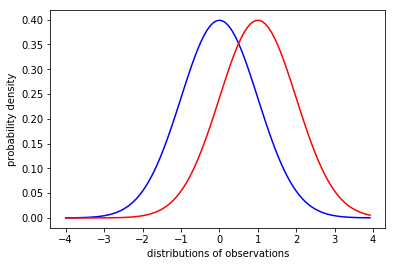

In [11]:
plot(x, norm_pdf(x, mu1, sd1), 'b-')
plot(x, norm_pdf(x, mu2, sd2), 'r-')
xlabel('distributions of observations')
ylabel('probability density');

### B, distribution of means of 16 observations.

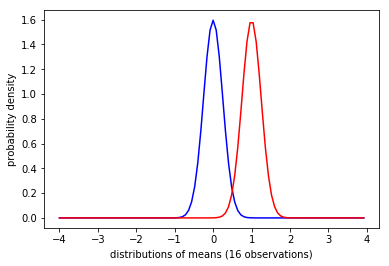

In [12]:
plot(x, norm_pdf(x, mu1, sd1/sqrt(n1)), 'b-')
plot(x, norm_pdf(x, mu2, sd2/sqrt(n1)), 'r-')
xlabel('distributions of means (16 observations)')
ylabel('probability density');

The standard deviation of means of 16 observations is:

In [13]:
print('Standard deviation of means = ', sd1/sqrt(n1)) 

Standard deviation of means =  0.25


In [14]:
effect_size = (mu2 - mu1) / sd1
print('Effect size=', effect_size)

Effect size= 1.0


In [15]:
power_analysis = TTestIndPower()
pwr = power_analysis.power(effect_size, n1, Psig)
print('Power =', pwr, 'for P =', Psig)

Power = 0.7813977845875587 for P = 0.05


## Figure 5. Result of simulated t-tests in the case where the null hypothesis is not true.

In [16]:
mean = np.array([mu1, mu2])
sigma = np.array([[sd1**2, 0.0], [0.0, sd2**2]]) #covariance matrix
nsim = 10000
diff, pval = run_simulation(mean, sigma, n1, nsim=nsim)

### A, The distribution of 'observed' differences between means of 16 observations.

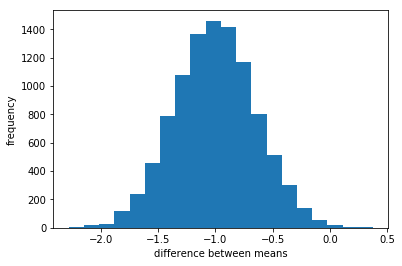

In [17]:
plt.hist(diff, bins=20);
xlabel('difference between means')
ylabel('frequency');

### B, The distribution of p-values. 

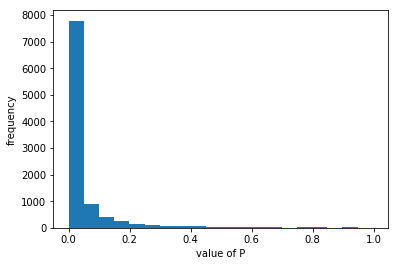

In [18]:
plt.hist(pval, bins=20);
xlabel('value of P')
ylabel('frequency');

In [19]:
nsig = pval[pval <= Psig].size
print("{0:.0f}% of 'significant' differences for 'significance' threshold P = {1:.2f}".
     format(100*nsig/nsim, Psig) + 
     '\nas expected from the calculated power {0:.3f}'.format(pwr))

78% of 'significant' differences for 'significance' threshold P = 0.05
as expected from the calculated power 0.781


In [20]:
#mean observed difference for expts with Pmin<P<=Pmax
meandiff = np.sum(diff[pval <= Psig]) / nsig
print("\n","Observed difference between means for 'sig' results = ", 
      meandiff, " True value = ", mu1-mu2)


 Observed difference between means for 'sig' results =  -1.1336682676481056  True value =  -1.0


The measured effect size is too big. This happens because experiments that have by a chance a larger than average effect size are more likely to be found 'significant' than those that happen to have small effect size. 

## Figure 6. Distribution of p-values from test like in Fig. 5 but with only 4 observations in each group, rather than 16. 

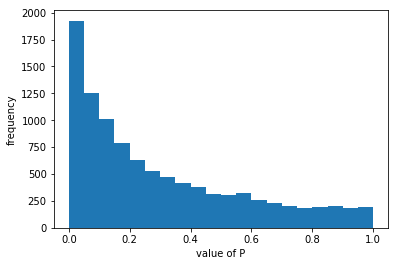

In [21]:
diff4, pval4 = run_simulation(mean, sigma, 4, nsim=nsim)
plt.hist(pval4, bins=20)
xlabel('value of P')
ylabel('frequency');

In [22]:
pwr4 = power_analysis.power(effect_size, 4, Psig)
print('Power =', pwr4, 'for P =', Psig)

Power = 0.2231880306351374 for P = 0.05


In [23]:
nsig4 = pval4[pval4 <= Psig].size
print("{0:.0f}% of 'significant' differences for 'significance' threshold P = {1:.2f}".
     format(100*nsig4/nsim, Psig))

19% of 'significant' differences for 'significance' threshold P = 0.05


In [24]:
#mean observed difference for expts with Pmin<P<=Pmax
meandiff4 = np.sum(diff4[pval4 <= Psig]) / nsig4
print("\n","Observed difference between means for 'sig' results = ", 
      meandiff4, " True value = ", mu1-mu2)


 Observed difference between means for 'sig' results =  -1.817982682897749  True value =  -1.0


## Figure 7. The average difference between means for tests where the power of the test was varied by changing the number of observations.

In [28]:
def produce_mean_effect_size(mean, sigma, nobs, Psig=0.005, nsim=10000):
    diff, pval = run_simulation(mean, sigma, nobs, nsim=nsim)
    nsig = pval[pval <= Psig].size
    meandiff = -np.sum(diff[pval <= Psig]) / nsig
    
    effect_size = (mean[0] - mean[1]) / sigma[0]
    power_analysis = TTestIndPower()
    pwr = power_analysis.power(effect_size, nobs, Psig)
    
    return pwr, meandiff

In [29]:
nobs = [4, 5, 6, 8, 10, 12, 14, 16, 20]
power_list = []
esize_list = []
for n in nobs:
    pw, md = produce_mean_effect_size(mean, sigma, n)
    power_list.append(pw)
    esize_list.append(md)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


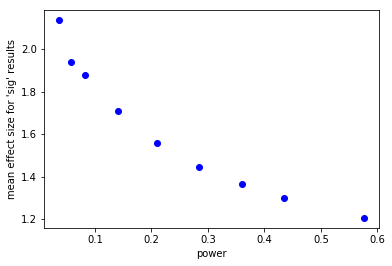

In [30]:
plot(power_list, esize_list, 'bo')
xlabel('power')
ylabel("mean effect size for 'sig' results");